In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from random import seed, shuffle
import os

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

from sklearn.cluster import KMeans, SpectralClustering

from scipy import stats
from scipy.spatial.distance import directed_hausdorff, euclidean, cosine, pdist

from src.downsample import downsamp_audio
import src.embedding_extractor as ee
import src.dimension_reducer as dr
import src.distance_metrics as dm

from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')

#from pydub import AudioSegment
#from pyannote.audio.utils.signal import Binarize, Peak
#from pyannote.core import Segment, notebook, SlidingWindowFeature, timeline, Timeline

#Specify path to codec exe used by pydub
#AudioSegment.converter='C:\\Users\\MrBrito\\Documents\\ffmpeg\\ffmpeg-2021-04-20-git-718e03e5f2-full_build\\ffmpeg-2021-04-20-git-718e03e5f2-full_build\\bin\\ffmpeg.exe'

one_samp_toy_dir = '/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/one_samp_toy_downsamp' #toy dataset with one participant recording @16kHz
#two_samp_toy_dir = '/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/two_samp_toy_downsamp'#toy dataset with two participant recordings @16kHz
two_samp_toy_dir ='/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/020422_postpartum_moms_two_samp_toy'
down_sampled_dir = '/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/downsamp'#all the data, downsampled to 16kHz
embedding_dir = '/Users/rahulbrito/Documents/projects/infantvoice/data/embeddings' #location of embeddings save new embeddings load pre-generated ones from here
emb_models = ['emb_ami', 'emb','emb_voxceleb'] #names of pretrained embedding extractor models

Using cache found in /Users/rahulbrito/.cache/torch/hub/pyannote_pyannote-audio_master
Using cache found in /Users/rahulbrito/.cache/torch/hub/pyannote_pyannote-audio_master


In [3]:
#the directory has other csvs and i only want today's
file = [file for file in os.listdir(embedding_dir) if file.startswith("020322")] 

#create a dictionary where each item is the pd df of the embeddings extracted from that model
all_embs = {emb_models[index]: ee.load_embs(os.path.join(embedding_dir,file[index])) for index in np.arange(len(file))}
emb_down = {model:ee.resample_data(emb,1) for model, emb in all_embs.items()}


In [5]:
plist = emb_down.part_id.unique().astype('int32') 

#loo is leave one out. Creates a dictionary of the downsampled embeddings with the format: {participant_removed:{embedding model:embeddings}} for each participant and embedding model
loo = {'rm' + str(p):
        {mod:
         ed[ed.part_id!=plst[p-1]].reset_index(drop=True) 
         for mod, ed in emb_down.items()
        } 
        for p in plst
       }

In [6]:
# Reduces dimensions of every set of leave-one-out
#Creates a dictionary: {participant_removed:{embedding model:two-dimension embeddings}} for each participant and embedding model with either tnse or umap
loo_tsne = {rm:
            {mod:dr.run_tsne(ed) 
             for mod, ed in ed_all.items()
            } 
            for rm, ed_all in loo.items()
           }

loo_umap = {rm:
            {mod:dr.run_umap(ed) 
             for mod, ed in ed_all.items()
            } 
            for rm, ed_all in loo.items()
           }
            

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [ ]:
#Calculates hausdorf distances between each participants point-cloud after dim reduc
#Creates a dictionary: {participant_removed:{embedding model:hausdorf distance}} for each participant and embedding model
#with hausdorff distances between each participant's two-dimension point-cloud, on either the tsne or umap
loo_haus_tsne = {rm:
             {mod:dm.hausdorff_distances(e2d) 
              for mod, e2d in e2d_all.items()
             } 
             for rm, e2d_all in loo_tsne.items()
            }

loo_haus_umap = {rm:
             {mod:dm.hausdorff_distances(e2d) 
              for mod, e2d in ed_all.items()
             } 
             for rm, ed_all in loo_umap.items()
            }

#flatten the hausdorf distances for plotting and only get column 2 which has the distances (0 and 1 have the pairs of participants)
loo_haus_tsne_flat = {rm:
                 {mod: haus.stack().reset_index().iloc[:,2]
                  for mod, haus in haus_all.items()
                 } 
                 for rm, haus_all in loo_haus_tsne.items()
                }

Processing row 3, col 13


<function matplotlib.pyplot.show(close=None, block=None)>

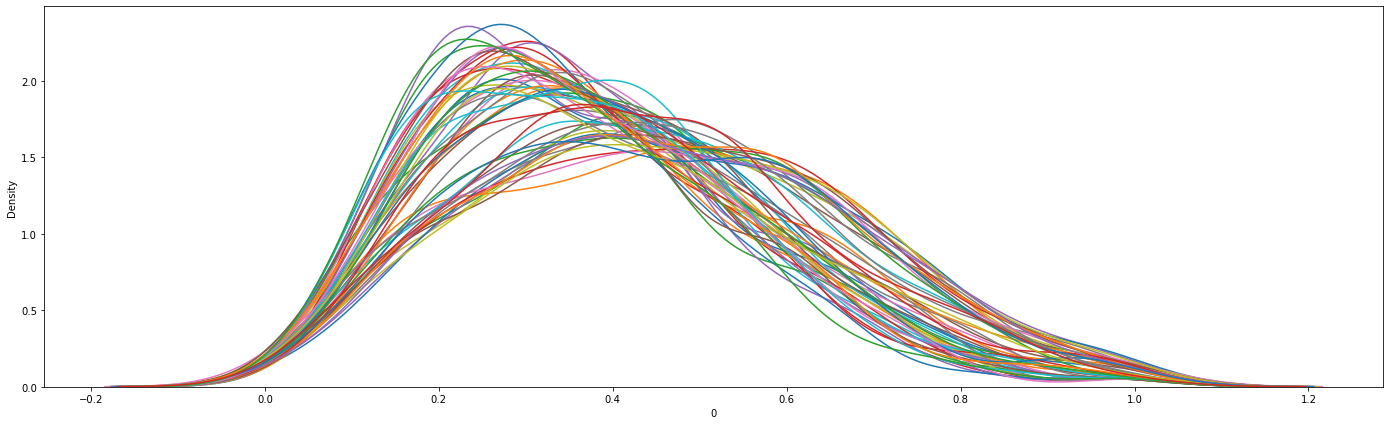

In [83]:
#plots distribution all hausdorff distances. Technically a histogram with easily viewing
fig, ax = plt.subplots(figsize=(24,7))#ncols=3
bins=100

#[plt.hist(dist[dist>0], bins) for haus in loo_haus_tsne_flat.values() for dist in haus.values()]
d_plot = [sns.distplot(dist[dist>0],hist=False) for haus in loo_haus_tsne_flat.values() for dist in haus.values()]
d_plot.set(xlim=(0,1))
plt.show